# Perform deconvolution using Richardson-Lucy on a grayscale image

## Load data and prepare operators

torch.Size([1, 1, 255, 255])



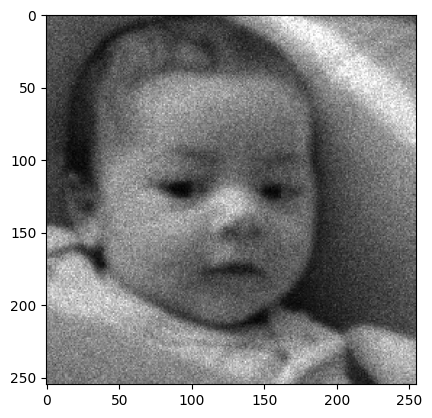

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import richardon_lucy as rl
import noise
import blur
from PIL import Image

device = "cuda"

k_size = 63
k_std = 2.0
n_std = 0.1
n_rate = 0.5

# Load the data
ref = Image.open('img/00000.png').convert('L')

ref = torch.from_numpy(np.array(ref)).unsqueeze(0).unsqueeze(0).to(device).float() / 255.0
ref = ref[:, :, :-1, :-1]

gaussianblur = blur.GaussianBlur(k_size, k_std).to(device)
k = gaussianblur.get_kernel().view(1, 1, k_size, k_size).to(device)

noiser = noise.PoissonNoise(n_rate)
# noiser = noise.GaussianNoise(n_std)

# Blur the image
y = gaussianblur(ref)

# Add noise
y = noiser(y)
plt.imshow(y[0, 0].detach().cpu().numpy(), cmap='gray')

## Perform the non-blind deconvolution

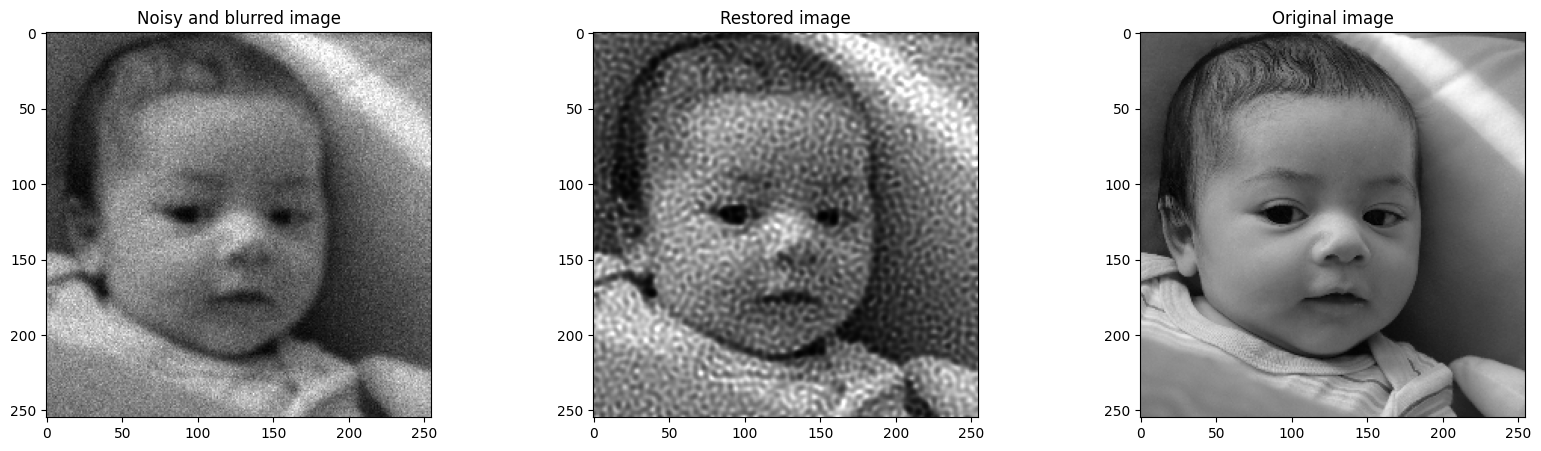

In [2]:
x_0 = torch.ones_like(y) 

res = rl.richardson_lucy(y, x_0, k, steps=50, clip=True, filter_epsilon=1e-6)

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.imshow(y[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Noisy and blurred image')
plt.subplot(1, 3, 2)
plt.imshow(res[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Restored image')
plt.subplot(1, 3, 3)
plt.imshow(ref[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Original image')
plt.show()

## Perform the blind deconvolution 

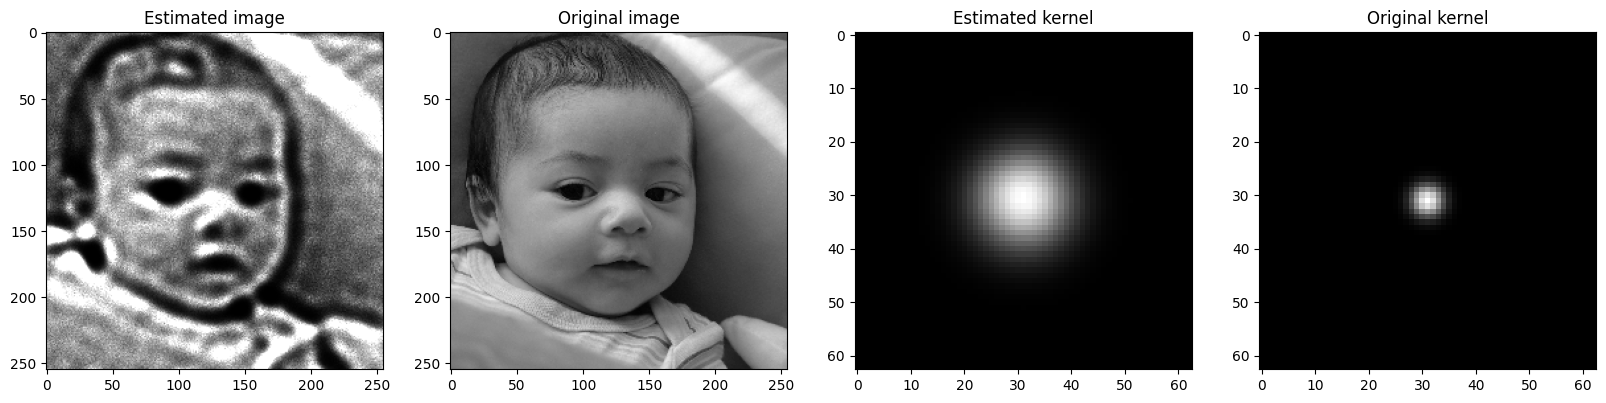

In [3]:
# Different initializations for the image
# x_0 = torch.ones_like(y)
x_0 = y


# Different initializations for the kernel
gaussianblur = blur.GaussianBlur(k_size, 6.0).to(device)

k_0 = gaussianblur.get_kernel().view(1, 1, k_size, k_size).to(device)
# k_0 = torch.ones_like(k) / torch.sum(torch.ones_like(k))
# k_0 = k

steps = 50
k_steps = 1
im_steps = 1

filter_epsilon = 1e-12
clip = True
observation = y

img_res, k_res = rl.blind_richardson_lucy(observation, x_0, k_0, steps=steps, clip=clip, filter_epsilon=filter_epsilon)


plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(img_res[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Estimated image')
plt.subplot(1, 4, 2)
plt.imshow(ref[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Original image')
plt.subplot(1, 4, 3)
plt.imshow(k_res[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Estimated kernel')
plt.subplot(1, 4, 4)
plt.imshow(k[0, 0].detach().cpu().numpy(), cmap='gray')
plt.title('Original kernel')
plt.show()

## Perform the blind deconvolution with an animation

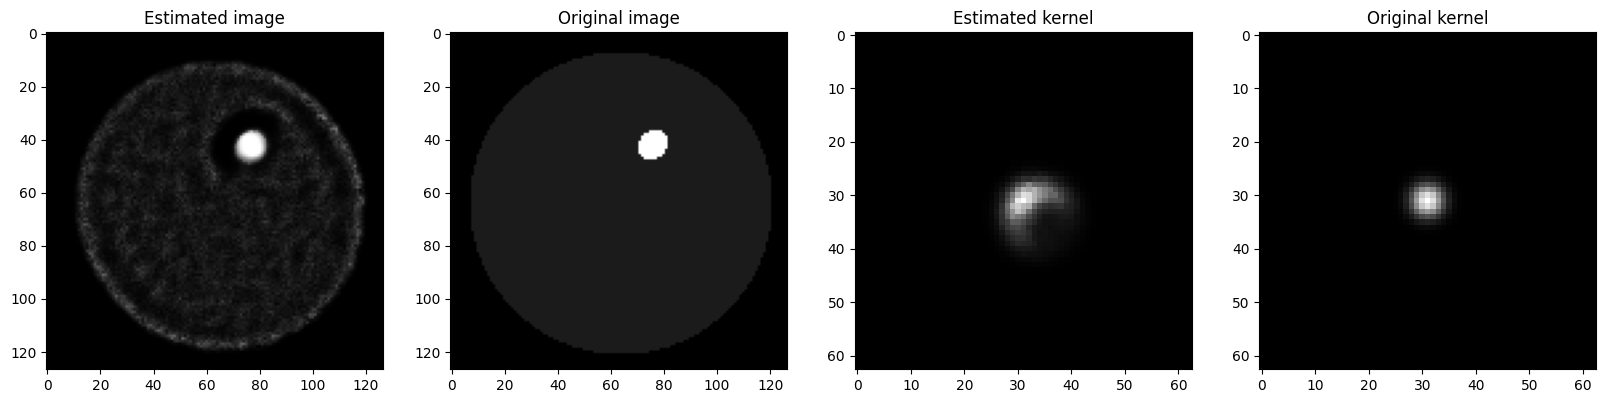

Step :  62


In [9]:
import torch.nn.functional as F
from IPython import display

# Different initializations for the image
# x_0 = torch.ones_like(y)
x_0 = y


# Different initializations for the kernel
gaussianblur = blur.GaussianBlur(k_size, 6.0).to(device)

k_0 = gaussianblur.get_kernel().view(1, 1, k_size, k_size).to(device)
# k_0 = torch.ones_like(k) / torch.sum(torch.ones_like(k))
# k_0 = k

steps = 100
k_steps = 1
im_steps = 1

filter_epsilon = 1e-12
clip = True
observation = y

with torch.no_grad():
    # kernel = x_0_hat['kernel'].repeat(1, 3, 1, 1)
    
    psf = k_0.clone().float()
    im_deconv = x_0.clone().float()
    k_T = torch.flip(psf, dims=[2, 3])  
    im_deconv_T = torch.flip(im_deconv, dims=[2, 3])

    eps = 1e-12
    pad_im = (psf.size(2) // 2, psf.size(2) // 2, psf.size(3) // 2, psf.size(3) // 2)
    pad_k = (im_deconv.size(2) // 2, im_deconv.size(2) // 2, im_deconv.size(3) // 2, im_deconv.size(3) // 2)
    
    # The issue is probably here
    
    for i in range(steps):
        
        # Kernel estimation
        # The issue with the offset is probably here, as there is no offset when using k as initialization
        
        for m in range(k_steps):      
              
            conv11 = F.conv2d(F.pad(im_deconv, pad_im, mode='replicate'), psf) + eps
            
            if filter_epsilon:
                relative_blur = torch.where(conv11 < filter_epsilon, 0.0, observation / conv11)
            else:
                relative_blur = observation / conv11
            
            im_mean = F.conv2d(torch.ones_like(F.pad(psf, pad_k)), im_deconv_T)
            # im_mean = F.conv2d(F.pad(torch.ones_like(psf), pad_k, mode='replicate'), im_deconv_T)
            
            if filter_epsilon:
                psf = torch.where(im_mean < filter_epsilon, 0.0, psf / im_mean)
            else:
                psf /= im_mean

            conv12 = F.conv2d(F.pad(relative_blur, pad_k, mode='replicate'), im_deconv_T) + eps
            conv12 = conv12[:,:,
                        conv12.size(2) // 2 - psf.size(2) // 2:conv12.size(2) // 2 + psf.size(2) // 2 + 1,
                        conv12.size(3) // 2 - psf.size(3) // 2:conv12.size(3) // 2 + psf.size(3) // 2 + 1]
            psf *= conv12

            # psf *= F.conv2d(F.pad(relative_blur, pad_im, mode='replicate'), im_deconv_T) + eps

            k_T = torch.flip(psf, dims=[2, 3]) 
        
        # Image estimation
        
        for n in range(im_steps):
            
            conv21 = F.conv2d(F.pad(im_deconv, pad_im, mode='replicate'), psf) + eps
            
            if filter_epsilon:
                relative_blur = torch.where(conv21 < filter_epsilon, 0.0, observation / conv21)
            else:
                relative_blur = observation / conv21
            
            # k_mean = F.conv2d(F.pad(torch.ones_like(im_deconv), pad_im, mode='replicate'), k_T)
            k_mean = F.conv2d(torch.ones_like(F.pad(im_deconv, pad_im)), k_T)
            if filter_epsilon:
                im_deconv = torch.where(k_mean < filter_epsilon, 0.0, im_deconv / k_mean)
            else:
                im_deconv /= k_mean
            
            im_deconv *= F.conv2d(F.pad(relative_blur, pad_im, mode='replicate'), k_T) + eps

        if clip:
            im_deconv = torch.clamp(im_deconv, 0, 1)
            
        im_deconv_T = torch.flip(im_deconv, dims=[2, 3])
        
        
        display.clear_output(wait=True)  # Clear the previous output

        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(im_deconv[0, 0].detach().cpu().numpy(), cmap='gray')
        plt.title('Estimated image')
        plt.subplot(1, 4, 2)
        plt.imshow(ref[0, 0].detach().cpu().numpy(), cmap='gray')
        plt.title('Original image')
        plt.subplot(1, 4, 3)
        plt.imshow(psf[0, 0].detach().cpu().numpy(), cmap='gray')
        plt.title('Estimated kernel')
        plt.subplot(1, 4, 4)
        plt.imshow(k[0, 0].detach().cpu().numpy(), cmap='gray')
        plt.title('Original kernel')
        plt.show()
        
        print("Step : ", i)